In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import scipy as sy
import scipy.stats
import pandas as pd
from scipy import ndimage
import PIL.Image
import math
import os
import string

from functions.statistical_analysis import correlate
from functions.statistical_analysis import comparison_distributions
from functions.math_tools import lin_fit
from functions.math_tools import line
from functions.plotting_tools import set_layout
from functions.plotting_tools import save_figures
from functions.genome_topology import Select_entangled_fraction


In [29]:
def length_L_pattern(imarray):    
    y=imarray.shape[0]
    x=imarray.shape[1]
    length_pattern=np.zeros(y-1)

    for i in range(y-1):
        step=0
        for j in range(i+1,x):
            if (imarray[i,j]==1):
                step=step+1        
            length_pattern[i]=step
    return length_pattern

def CreateDf_SegmentComparison(dataframe, method):
    df_plot={'Cell':dataframe['Cell'], 'Chr ID':dataframe['Chr ID'], 'Selection':dataframe[method]}
    df_plot=pd.DataFrame(data=df_plot)
    return df_plot

def Plot_SegmentComparison(df_segment_comparison, segments, clustering = None):
    cell = df_segment_comparison.columns[0]
    chrID= df_segment_comparison.columns[1]
    selection = df_segment_comparison.columns[2]
    df_segment_comparison=df_segment_comparison.pivot(cell, chrID, selection)
    
    g = plt.figure()
    ax= sns.heatmap(df_segment_comparison, cbar_kws={'label': 'Segment'})
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(segments)
    
    if clustering:
        plt.title('L loops local {}, {}'.format(method[-6:].lower(), clustering))
    else:
        plt.title('L loops local {}'.format(method[-6:].lower()))
        
    plt.tight_layout()
    return g


# LOCAL TOPOLOGICAL ANALYSIS FROM CHROMOSOME SEGMENTS 

This notebook presents examples of statistical analysis performed on topology matrices from chromosome segments. We measure the length of the L patterns for each segments (either by sum or mean of each L pattern in the segment). The size of the L patterns is expressed in number of contacts.
- By quantile analysis, we divide the L patterns into 'small' and 'big' (above and below the median). 
- We create 'bar codes' for visualizing the length of the L pattern in all segments of the chromosome
- We create heatmaps showing a particular characteristic of the L patterns in all chromosomes: ex, in which segment lies the maximum length L patterns in that chromosome? In which segment lies the minimum?

## 1. BUILD L-LOOPS LENTH DATAFRAME

Load topological matrices of chromosome segments from 'local analysis'

In [4]:
path ='local analysis/matrices/cell1'
cell=path[-5:]
n_all_chr=20 

#Read file names
files = os.listdir(path)
files_tif = [f for f in files if f[-3:] == 'tif']
len_dataset=len(files_tif)

#Chromosome names
letters=list(string.ascii_lowercase)
chr_vec=['chr {}'.format(letter) for letter in letters[:n_all_chr]]

print('Analyzing cell {}'.format(cell[-1:]))

Analyzing cell 1


Create dataframe with loop (L pattern) lengths per each chromosome segment

In [6]:
df=pd.DataFrame()

n_segments=8
length_tot=[]
n_contacts=[]
chr_ID=[]
segment=[]
n_chr=20


for t in range(n_segments*n_chr):
    x, y= np.unravel_index(t,(n_chr, n_segments))
    
    file = 'matrix_{}_{}.tif'.format(chr_vec[x], y)
    
    #Check if matrix file exists. If not, no contacts were found in that segment
    if (file in files_tif):
        im = PIL.Image.open('{}/{}'.format(path,file))
        imarray = np.array(im)
        chromosome=file[-11:-6]
        seg=file[-5:-4]
         
        #Process matrices to select only entangled fraction    
        imarray = Select_entangled_fraction(imarray)
        #Measure length of L loops
        length=length_L_pattern(imarray)
        size=imarray.shape[0]
        index=np.linspace(0, len(length),len(length))
   
        length=length[length!=0.]
        length_tot.append(length)    
    
        n_contacts.append(size)
        chr_ID.append(chromosome)
        segment.append(seg)
    else:
        seg=file[-5:-4]
        chromosome=file[-11:-6]
        length_tot.append([])
        n_contacts.append([])
        chr_ID.append(chromosome)
        segment.append(seg)

#Create dataframe
length_tot=tuple(length_tot)    
df['length']=pd.Series(length_tot)  
df['n contacts']=pd.Series(n_contacts)
df['Chr ID']=pd.Series(chr_ID)
df['Segment']=pd.Series(segment)


Add statistical analysis of loops to dataframe (mean, sum, quatile analysis)

In [8]:
length_db=len(df)
mean_small_vec=np.zeros(length_db)
mean_big_vec=np.zeros(length_db)
mean=np.zeros(length_db)
sum_loops=np.zeros(length_db)

for t in range(length_db):
    loop_string= df['length'][t]    
    if (np.array(loop_string).size != 0):
        try:
            col=pd.qcut(loop_string,2, labels=[ "small","big"])
            df_loops={'loop':loop_string, 'classification': col}
            df_loops=pd.DataFrame(data=df_loops)
            mean_small=np.mean(df_loops[df_loops['classification']=='small'])
            mean_big=np.mean(df_loops[df_loops['classification']=='big'])
            mean_small_vec[t]=mean_small
            mean_big_vec[t]=mean_big
        except: 
            mean_small_vec[t]=0
            mean_big_vec[t]=0
        mean[t]=np.mean(loop_string)
        sum_loops[t]=np.mean(loop_string)
    else:
        mean[t]=0
        sum_loops[t]=0
        mean_small_vec[t]=0
        mean_big_vec[t]=0
    
#Add info to dataframe    
df['Mean']=mean 
df['Mean small']=mean_small_vec
df['Mean big']=mean_big_vec
df['Sum']=sum_loops
cell_vec=[cell]*len(df)
df['Cell']=pd.Series(cell_vec)

#Save dataframe to csv
df.to_csv('local analysis/matrices/{}/local_loops_{}.csv'.format(cell, cell))

## 2. PLOT LOCAL DATA AS BAR PLOTS

Load dataframe with L pattern lengths (local_loops_{}.csv). Choose wich cell you want to analyze

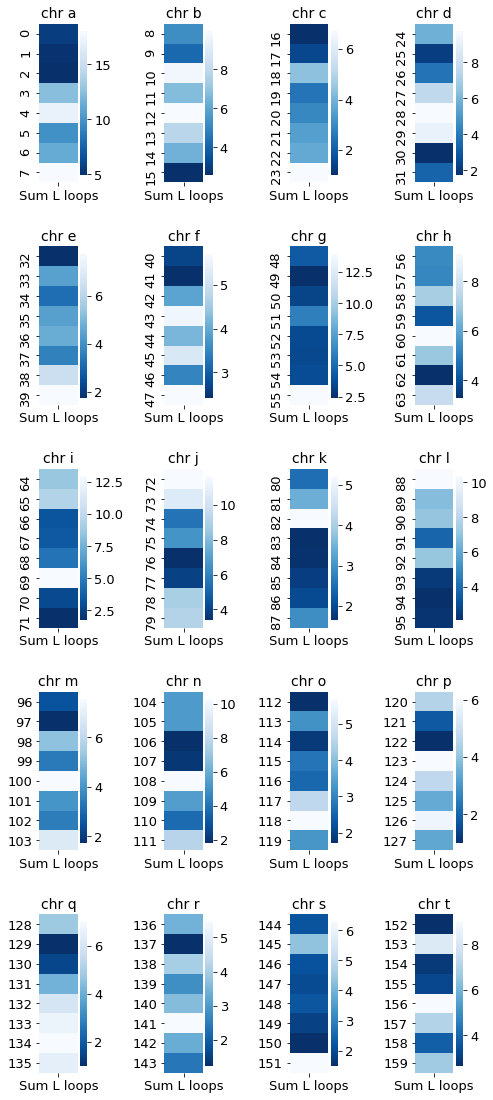

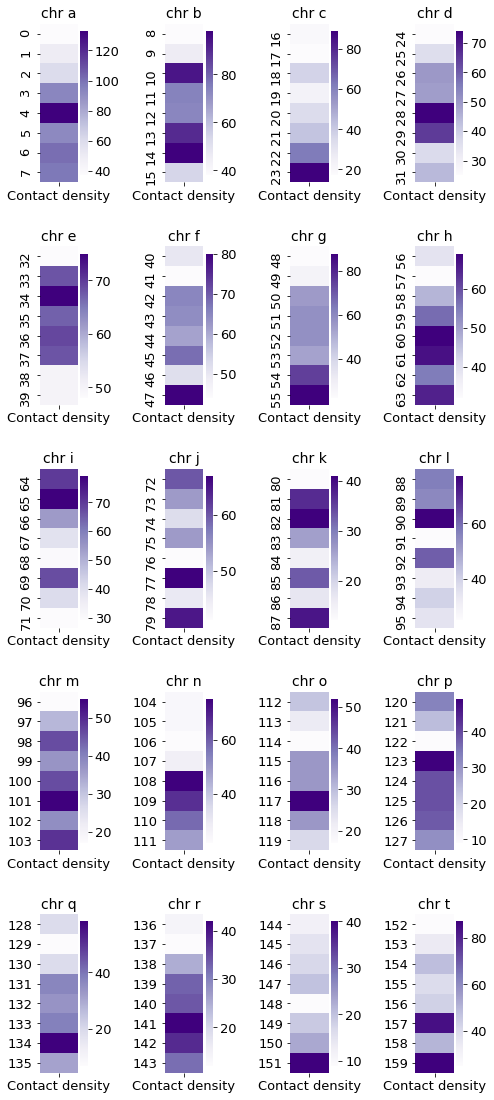

In [3]:
cell='cell1'
df = pd.read_csv('local analysis/matrices/{}/local_loops_{}.csv'.format(cell,cell))
chromosomes=np.unique(df['Chr ID'])
n_all_chr= len(chromosomes)
width_figure=7.5
length_figure=16
set_layout()

#Plot barcode L-loops for all chromosomes in a cell
fig, ax = plt.subplots(nrows=5, ncols=4,figsize=(width_figure,length_figure))
fig.tight_layout(pad=3.0)


for t in range(n_all_chr):
    df_chr=df[df['Chr ID']==chromosomes[t]]

    map_chr=df_chr['Sum']
    df_seg={'Sum L loops': map_chr}
    df_seg=pd.DataFrame(data=df_seg)
    
    i,j=np.unravel_index(t,(5,4))
    ax[i,j].set_title('{}'.format(chromosomes[t]))
    sns.heatmap(df_seg, cmap='Blues_r', ax = ax[i,j])

#fig.savefig('results/figures/all_chr_{}_2.jpg'.format(cell), bbox_inches='tight')
#fig.savefig('results/figures/all_chr_{}_2.eps'.format(cell), bbox_inches='tight')

#Plot barcode contacts for all chromosomes in a cell
fig, ax = plt.subplots(nrows=5, ncols=4,figsize=(width_figure,length_figure))
fig.tight_layout(pad=3.0)
  
for t in range(n_all_chr):
    df_chr=df[df['Chr ID']==chromosomes[t]]
    map_chr=df_chr['n contacts']
    df_seg={'Contact density': map_chr}
    df_seg=pd.DataFrame(data=df_seg)
    i,j=np.unravel_index(t,(5,4))
    ax[i,j].set_title('{}'.format(chromosomes[t]))
    sns.heatmap(df_seg, cmap='Purples', ax = ax[i,j])
    
#fig.savefig('results/figures/all_chr_contacts{}_2.jpg'.format(cell), bbox_inches='tight')
#fig.savefig('results/figures/all_chr_contacts{}_2.eps'.format(cell), bbox_inches='tight')

## 3. LOCAL ANALYSIS, COMPARISON BETWEEN CELLS

Choose the path for your figures:

In [37]:
path_figure='results/figures'

First of all, we calculate the correlation between L-loops and contacts

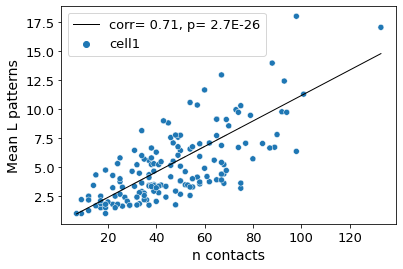

In [5]:
name_figure='corr_contacts_Lloops'
corr, pvalue = correlate(df['n contacts'], df['Mean'])

plot=plt.figure()
sns.scatterplot(x='n contacts', y='Mean', hue='Cell', data=df)
y=lin_fit(df['n contacts'], df['Mean'])
sns.lineplot(x = df['n contacts'],y= y, color='k', linewidth = 1.0, label='corr= {}, p= {}'.format(corr, pvalue))
plt.ylabel('Mean L patterns');

#save_figures(plot,path_figure, name_figure)

Load L-loops data from all cells

In [14]:
cells=['cell{}'.format(int(number)) for number in np.arange(1,9,1)]
df=pd.DataFrame()

for cell in cells:
    df_single = pd.read_csv('local analysis/matrices/{}/local_loops_{}.csv'.format(cell, cell))
    frames = [ df, df_single]
    df=pd.concat(frames)
    
chr_names=np.unique(df['Chr ID'])    
n_chromosomes=len(chr_names)
segments= np.unique(df['Segment'])
segments_label= segments+np.ones(len(segments))

Plot barcode of same chromosome, all cells

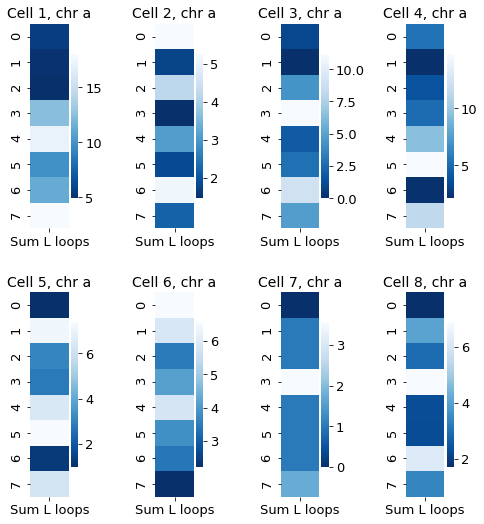

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(7.5,8))
fig.tight_layout(pad=3.0)
name_file= 'Comparison single chr local analysis'

chosen_chr= 0
for t in range(len(cells)):
    df_cell=df[df['Cell']==cells[t]]
    df_chr=df_cell[df_cell['Chr ID']==chromosomes[chosen_chr]]

    map_chr=df_chr['Sum']
    df_seg={'Sum L loops': map_chr}
    df_seg=pd.DataFrame(data=df_seg)
    
    i,j=np.unravel_index(t,(2,4))
    ax[i,j].set_title('Cell {}, {}'.format(t+1, chr_names[chosen_chr]))
    sns.heatmap(df_seg, cmap='Blues_r', ax = ax[i,j])
    
    
#save_figures(fig,path_figures,name_file)

Process data to find in which segment of the chromosome we have minima and maxima in loop size

In [25]:
len_index=n_chromosomes*len(cells)
min_array=np.zeros(len_index)
max_array=np.zeros(len_index)
chrom_array=['']*len_index
cell_array=['']*len_index
min_array_sum= np.zeros(len_index)
max_array_sum= np.zeros(len_index)
#max_label_array= np.zeros(len_index)


index=0
for cell in cells:
    for t in range(n_chromosomes):
        df_chr=df[(df['Chr ID']==chr_names[t]) & (df['Cell']==cell)]
        
        #MEAN

        max_mean=df_chr['Mean'].max()
        max_pos=df_chr['Segment'][df_chr['Mean']==max_mean]
        min_mean=df_chr['Mean'].min()
        min_pos=df_chr['Segment'][df_chr['Mean']==min_mean]
        min_array[index]=int(min_pos.array[0])+1
        max_array[index]=int(max_pos.array[0])+1
        chrom_array[index]=t
        cell_array[index]=cell
        
        #SUM
        
        max_sum=df_chr['Sum'].max()
        max_pos=df_chr['Segment'][df_chr['Sum']==max_sum]
        min_sum=df_chr['Sum'].min()
        min_pos=df_chr['Segment'][df_chr['Sum']==min_sum]
        min_array_sum[index]=int(min_pos.array[0])+1
        max_array_sum[index]=int(max_pos.array[0])+1
              
        index=index+1         

#Store data in dataframe
df_comparison={'Chr ID': chrom_array, 'Cell': cell_array, 'Mean Minima': min_array, 'Mean Maxima': max_array, 
              'Sum Minima':min_array_sum, 'Sum Maxima':max_array_sum}

df_comp=pd.DataFrame(data=df_comparison)

Divide dataset into high and low clustering cells

In [27]:
df_comp_highclust=df_comp[(df_comp['Cell']=='cell1')|(df_comp['Cell']=='cell4')|(df_comp['Cell']=='cell6')|(df_comp['Cell']=='cell8')]
df_comp_lowclust=df_comp[(df_comp['Cell']=='cell2')|(df_comp['Cell']=='cell3')|(df_comp['Cell']=='cell5')|(df_comp['Cell']=='cell7')]

PLOT LOCAL ANALYSIS AS HEATMAPS, CELL COMPARISON

Choose the what you want to plot in the heatmap:
 - methods= Mean Minima, Mean Maxima, Sum Minima, Sum Maxima
 - dataframe = df_comp, df_comp_highclust, df_comp_lowclust

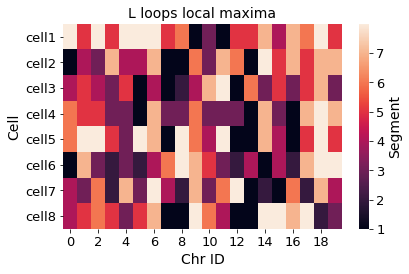

In [32]:
dataframe = df_comp
method = 'Sum Maxima'
name_file='L loops comparison'

df_heatmap=CreateDf_SegmentComparison(dataframe, method)
plot = Plot_SegmentComparison(df_heatmap, segments)

#Save figure
save_figures(plot,path_figure, name_file, method)

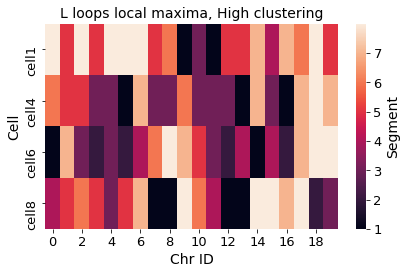

In [39]:
dataframe = df_comp_highclust
method = 'Sum Maxima'
#name_file='L loops comparison high clustering'
name_file='pollo'

df_heatmap=CreateDf_SegmentComparison(dataframe, method)
plot = Plot_SegmentComparison(df_heatmap, segments, clustering = 'High clustering')

save_figures(plot,path_figure, name_file, method)

## 4. CREATE GROUPINGS AMONG CHROMOSOMES, COMPARE THEIR DISTRIBUTIONS

Load connectivity data 

In [41]:
xls=pd.ExcelFile('data/data_allcells_connectivity.xlsx')
df_allcells = pd.read_excel(xls)
high_clust=df_allcells[(df_allcells['Cell']==1)|(df_allcells['Cell']==4)|(df_allcells['Cell']==6)|(df_allcells['Cell']==8)]
low_clust=df_allcells[(df_allcells['Cell']==2)|(df_allcells['Cell']==3)|(df_allcells['Cell']==5)|(df_allcells['Cell']==7)]

Create groupings among chromosomes, based on heatmaps

In [44]:
#This grouping is based on what chromosomes reach maximum in their first segment, and which don't.
#(8 segments per chromosome)
grouping = ['y', 'n', 'n', 'n', 'n', 'y', 'n', 'y', 'y', 'y', 'n', 'y', 'y', 'y', 'y', 'y', 'y', 'n', 'n', 'n']
grouping_allcells=grouping*8
df_allcells['Grouping']=grouping_allcells

Plot connectivity of the two groups

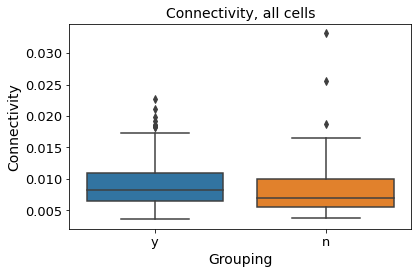

In [45]:
set_layout()
name_file='grouping_connectivity'
g=plt.figure()
ax = sns.boxplot(x="Grouping", y="Connectivity", data=df_allcells)
plt.title('Connectivity, all cells')
plt.tight_layout()

#save_figures(g,path_figure, name_file)

Compare the two distributions

In [46]:
dist1=df_allcells['Connectivity'][df_allcells['Grouping']=='y']
dist2=df_allcells['Connectivity'][df_allcells['Grouping']=='n']

test = comparison_distributions(dist1, dist2)

the distributions are not normal: 1.1603742677834816e-06, 1.2121444958879124e-09
The distributions have equal variance: 0.9629422440862496
Mannwhitneyu test: False = 0.04862700226024149


Another example of grouping (4 segments per chromosome)